 # AUTOMATIC CHORD-SCALE DETECTION & STUDENT PERFORMANCE ASSESMENT FOR JAZZ IMPROVISATION
 
 ## PART 1 : ANALYSIS ON CHORD-SCALE DATASET

In [10]:
import sys,os
sys.path.append(os.path.join(os.path.dirname('__file__'), 'freesound-python/'))

import numpy as np

import freesound
client = freesound.FreesoundClient()
client.set_token("1Dio5sf5Kq7uxPPi4WSQljr4EncEzRjuVdlMV8z8","token")

from IPython.display import Audio
from IPython.core.display import display, HTML, Image

from utilities import *


#CHORD-SCALE DATASET on freesound.org
freesound_PACK_ID = 24075

DOWNLOADSOUNDS = False ### SET 'True' FOR DOWNLOADING THE SOUNDS FROM FREESOUND, SET 'False' IF SOUNDS ALREADY EXIST

#Directory for audio files
audioDir = 'audio/'
#Directory for audio segment annotations
annotationsDir = 'scale_annotations/'
#Directory for Feature Data (.csv and pickle files)
dataDir = 'data/'

#ANALYSIS PARAMETERS FOR FEATURE EXTRACTION

params=AnalysisParams(200,100,'hann',2048,44100,12)

#INITIATE PROPER DATA STRUCTURE
dataDictionary = createDataStructure(annotationsDir) 

### DOWNLOAD THE 'CHORD-SCALE PACK (OR dataset)' FROM FREESOUND

In [11]:
if os.path.exists(audioDir) != 1:
    os.mkdir(audioDir)

pack = client.get_pack(freesound_PACK_ID)
print("Pack name:", pack.name)

results_pager = pack.get_sounds(page_size=50,fields="id,name,username,duration,previews")
 
scaleTypes = []    
TotalDuration = []
for sound in results_pager:
    
    SOUND_NAME = sound.name.split('.')[0]
    TotalDuration.append(sound.duration)
    if DOWNLOADSOUNDS:
        sound.retrieve_preview(audioDir,SOUND_NAME+".mp3")   
    
    ## dataDict[sound.name][0] has the 'duration' & 'freesoundid' information
    dataDictionary[SOUND_NAME][0]['duration']= sound.duration
    dataDictionary[SOUND_NAME][0]['freesoundid'] = sound.id

print("Number of sounds :", results_pager.count)   
print("Total duration of the dataset : " , np.sum(TotalDuration)/60.0, 'min')

Pack name: Chord-Scale Dataset
Number of sounds : 41
Total duration of the dataset :  43.9691983333 min


### DISPLAY DATA

In [12]:
scaleType = 'mixolydian'

SoundsList = []
freesoundids = []
for sound in dataDictionary.items():
    if scaleType in sound[0].split('_')[1]:
        SoundsList.append(sound)
        freesoundids.append(sound[1][0]['freesoundid'])
        
html = "<h3 style='color:#bb;'>%i) %s</h3>" % (1,scaleType)
html += "<h4>Example sound:</h4><br>"
html += generate_html_with_sound_examples(freesoundids)
html += "<br><br>"
display(HTML(html))

### FEATURE EXTRACTION


In [13]:
'''
DEFINE PARAMETERS FOR FEATURE EXTRACTION

    - AnalysisParams:
        windowSize = 200ms
        hopSize = 100ms
        windowFunction = 'hanning'
        fftN (fftSize) = 2048
        fs (sampleRate) = 44100
        numBins (HPCP Resolution) = 12 bins/octave
        
'''
if os.path.exists(dataDir) != 1:
    os.mkdir(dataDir)       

#### FEATURE EXTRACTION ####

for fileName,parts in dataDictionary.items():
    #print(fileName)
    for part in parts:
        computeHPCP_FRAMEBASED(part,params)
        computeHPCP_GLOBAL(part) 
        
#Saving all results in a pickle file
pickleProtocol=1#choosen for backward compatibility
with open(os.path.join('data','HPCPFeaturesExtracted_ChordScaleDataset.pkl') , 'wb') as f:
    pickle.dump(dataDictionary, f, pickleProtocol)

#Let's clear data and re-read it
print('HPCP (Chroma) Features extracted and saved in a file')                

HPCP (Chroma) Features extracted and saved in a file


### METHOD 1 : TEMPLATE-BASED LIKELIHOOD ESTIMATION


In [14]:
### FIRST, LET'S DEFINE A DICTIONARY THAT CONTAINS ALL THE PREDEFINED SCALE TEMPLATES

ScaleTemplates = dict()
    
ScaleTemplates['major'] = {'scaleArray':[1,0,1,0,1,1,0,1,0,1,0,1]}
ScaleTemplates['dorian'] = {'scaleArray':[1,0,1,1,0,1,0,1,0,1,1,0]}
ScaleTemplates['phrygian'] = {'scaleArray':[1,1,0,1,0,1,0,1,1,0,1,0]}
ScaleTemplates['lydian'] = {'scaleArray':[1,0,1,0,1,0,1,1,0,1,0,1]}
ScaleTemplates['mixolydian'] = {'scaleArray':[1,0,1,0,1,1,0,1,0,1,1,0]}
ScaleTemplates['minor'] = {'scaleArray':[1,0,1,1,0,1,0,1,1,0,1,0]}
ScaleTemplates['locrian'] = {'scaleArray':[1,1,0,1,0,1,1,0,1,0,1,0]}
ScaleTemplates['lydianb7'] = {'scaleArray':[1,0,1,0,1,0,1,1,0,1,1,0]}
ScaleTemplates['altered'] = {'scaleArray':[1,1,0,1,1,0,1,0,1,0,1,0]}
ScaleTemplates['mminor'] = {'scaleArray':[1,0,1,1,0,1,0,1,0,1,0,1]}
ScaleTemplates['hminor'] = {'scaleArray':[1,0,1,1,0,1,0,1,1,0,0,1]}
ScaleTemplates['hwdiminished'] = {'scaleArray':[1,1,0,1,1,0,1,1,0,1,1,0]}

Maximum Likeliest Scale of Phrase : lydianb7    with likeliest : 0.115834981687


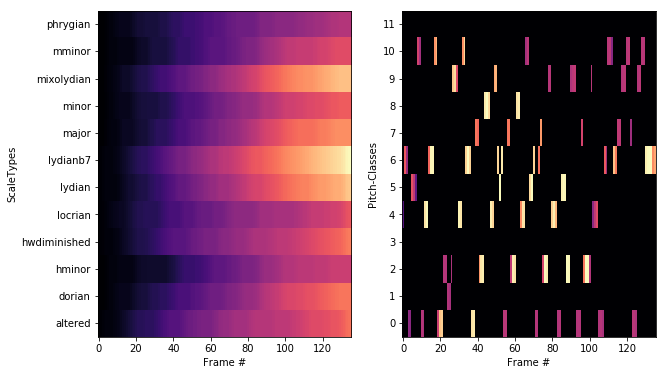

In [15]:
### NOW, LET'S LOAD THE FEATURE DATA WE OBTAINED IN THE PREVIOUS STEPmaxlikelihood2

FEATUREDATA = os.path.join('data','HPCPFeaturesExtracted_ChordScaleDataset.pkl')
with open(FEATUREDATA , 'rb') as f:
    dataDictionary = pickle.load(f)
    
### CHOOSE THE SOUND

SAMPLESOUND = 'toprak_lydianb7'

### CHOOSE THE AUDIO SEGMENT FOR ANALYSIS

NUMSegment = 3

### and THE CHORD-SCALE ESTIMATION METHOD; 1 - Multiplicative, 2 - Additive 

LikelihoodMethod = 2

VisualizeChromaANDScaleLikelihoods(FEATUREDATA,SAMPLESOUND,NUMSegment,ScaleTemplates,LikelihoodMethod)

Overall Accuracy using Likelihood Estimation for Method ( 1 ) and using mean HPCPs, is 69.1304347826087
Overall Accuracy using Likelihood Estimation for Method ( 2 ) and using mean HPCPs, is 77.82608695652173
Overall Accuracy using Likelihood Estimation for Method ( 1 ) and using std HPCPs, is 69.1304347826087
Overall Accuracy using Likelihood Estimation for Method ( 2 ) and using std HPCPs, is 77.39130434782608


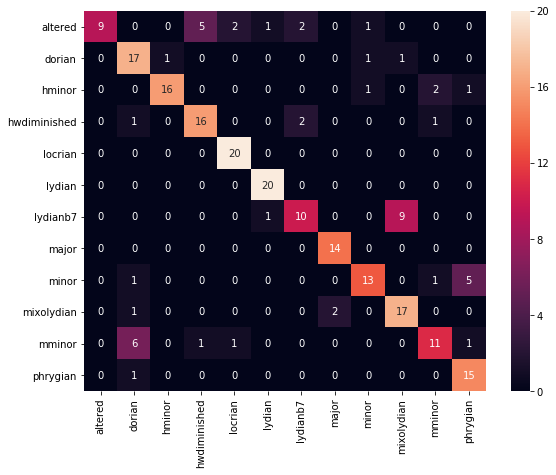

In [16]:
features = ['mean','std']
LikelihoodMethods = [1,2] ### 1 - Weiss (2014) method (multiplicative approach), 2 - Demirel method (additive approach)

overall_accuracy_list = []
for feature in features:
    for i in LikelihoodMethods : 
        overall_accuracy = Classification_Likelihood(dataDictionary,ScaleTemplates,i, feature)
        overall_accuracy_list.append(overall_accuracy)
        print('Overall Accuracy using Likelihood Estimation for Method ( ' + str(i) + ' ) and using ' + feature + ' HPCPs, is ' + str(overall_accuracy))

VisualizeConfusionMatrix_Likelihood(dataDictionary,ScaleTemplates)
        

### METHOD 2 : CLASSIFICATION USING SVMS

This process might take a while (5-10 min) 
 CROSS-VALIDATION & TRAINING 
Accuracy score for the Feature Set : 

F-measure (mean,std) --- FINAL 

0.68 0.109682572684
Accuracy (mean,std) FINAL 

0.72 0.0896327309917


Accuracy score for the Feature Set : 

F-measure (mean,std) --- FINAL 

0.72 0.0687426598532
Accuracy (mean,std) FINAL 

0.76 0.0622513959273


Accuracy score for the Feature Set : 

F-measure (mean,std) --- FINAL 

0.71 0.0801222548321
Accuracy (mean,std) FINAL 

0.75 0.0722315118515


Confusion matrix, without normalization


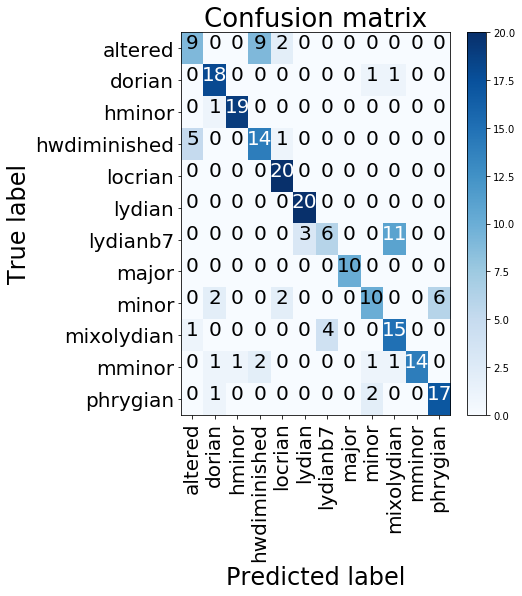

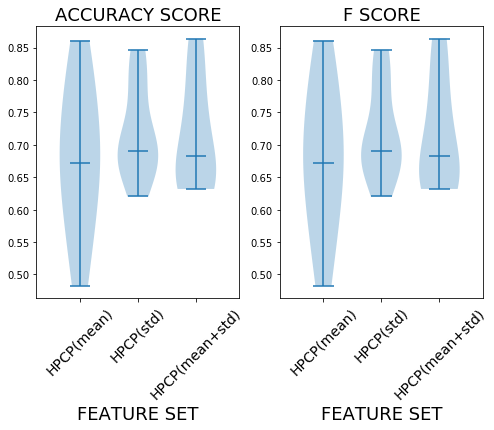

In [17]:
DATA_accuracy = []
DATA_fscore = []

print('This process might take a while (5-10 min) \n CROSS-VALIDATION & TRAINING ') 

for i in range(3):
    FeatureSelection('HPCPFeaturesExtracted_ChordScaleDataset.pkl',dataDir,(i+1))  
    ACCURACY, F_SCORE, CONFUSION_MATRIX, LABELS = Classification_SVM('FeaturesData_ChordScaleDataset.csv',dataDir)
    DATA_accuracy.append(ACCURACY)
    overall_accuracy_list.append(np.mean(ACCURACY)*100)
    DATA_fscore.append(F_SCORE)

plot_confusion_matrix(CONFUSION_MATRIX,LABELS,normalize=False)    ### PLOT CONFUSION MATRIX ONLY FOR THE BEST PERFORMING FEATURE SET COMBINATION
plot_VIOLINPLOT(DATA_accuracy,DATA_fscore) 

In [18]:
overall_accuracy_list

[69.1304347826087,
 77.82608695652173,
 69.1304347826087,
 77.39130434782608,
 67.869565217391298,
 71.888198757763973,
 71.333333333333343]